In [6]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
import warnings

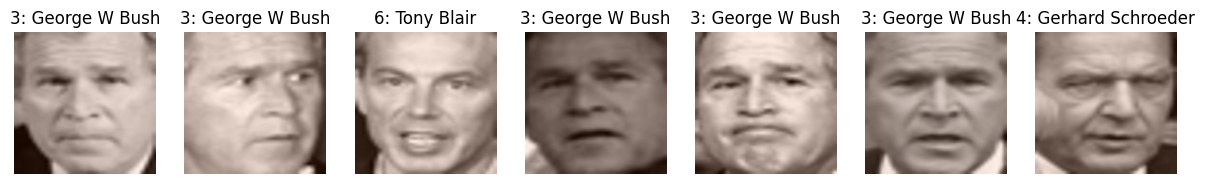

In [7]:
# Загрузка данных LFW
lfw_people = fetch_lfw_people(min_faces_per_person=80, resize=0.4)

# Получение изображений и имен
images = lfw_people.images
target_names = lfw_people.target_names
X = lfw_people.data
y = lfw_people.target
n_classes = target_names.shape[0]
# Преобразование изображений в формат (224, 224, 3)
n_samples, h, w = lfw_people.images.shape
X_resized = np.zeros((n_samples, 224, 224, 3))

for i in range(n_samples):
    # Преобразуем каждое изображение из одномерного массива в 2D
    img = X[i].reshape(h, w)
    # Преобразуем в RGB и изменяем размер
    img = Image.fromarray(np.uint8(img * 200))  # Умножаем на 255 для преобразования в формат uint8
    img = img.convert('RGB')  # Конвертируем в RGB
    img = img.resize((224, 224))  # Изменяем размер
    X_resized[i] = img_to_array(img)  # 

# Нормализация изображений
X_resized = preprocess_input(X_resized)

# Преобразование меток в one-hot encoding
encoder = OneHotEncoder()
y_onehot = encoder.fit_transform(y.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)


# Количество изображений для отображения
n_images = 7

# Настройка графиков
plt.figure(figsize=(15, 8))

for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(array_to_img(X_test[i]))
    plt.title(f"{y_test[i]}: {target_names[y_test[i]]}")
    plt.axis('off')

plt.show()


In [8]:
# Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Пример использования
datagen.fit(X_train)

# Создаем генераторы для обучающей и валидационной выборки
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

# Загрузка VGG16 без верхнего слоя
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model.fit(train_generator, 
          steps_per_epoch=len(X_train) // 32, 
          epochs=10, 
          validation_data=validation_generator, 
          validation_steps=len(X_test) // 32)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2918 - loss: 15.8946 - val_accuracy: 0.4766 - val_loss: 1.6297
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 492ms/step - accuracy: 0.5312 - loss: 1.7845 - val_accuracy: 0.4570 - val_loss: 1.6283
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4070 - loss: 1.6533 - val_accuracy: 0.4922 - val_loss: 1.4265
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.4062 - loss: 1.6939 - val_accuracy: 0.5273 - val_loss: 1.4103
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4439 - loss: 1.6029 - val_accuracy: 0.5703 - val_loss: 1.2355
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.2500 - loss: 1.6097 - val_accuracy: 0.5547 - val_loss: 1.1875
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4646 - loss: 1.4314 - val_accuracy: 0.5273 - val_loss: 1.2558
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.5938 - loss: 1.5245 - val_accuracy: 0.558

In [15]:
from sklearn.model_selection import train_test_split

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6390 - loss: 0.7823
Loss: 0.8346577882766724, Accuracy: 0.6085271239280701


In [16]:
model.save('face_recognition_model_v7.keras')  

## Тест

In [21]:
i = 9 # выбор картинки из тестовой выборки

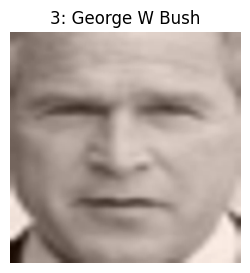

In [22]:
plt.figure(figsize=(7, 3))
plt.imshow(array_to_img(X_test[i]))
plt.title(f"{y_test[i]}: {target_names[y_test[i]]}")
plt.axis('off')
plt.show()

In [23]:
prediction = model.predict(np.expand_dims(X_test[i].reshape(224, 224, 3), axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [24]:
print(f"распознан класс: {np.argmax(prediction)}")

распознан класс: 3


# Тестирование с моими картинками

In [33]:
model = load_model('face_recognition_model_v4.keras')

In [34]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    embedding = model.predict(img_array)
    return embedding

your_image_embedding = get_embedding("vlada_images/1.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


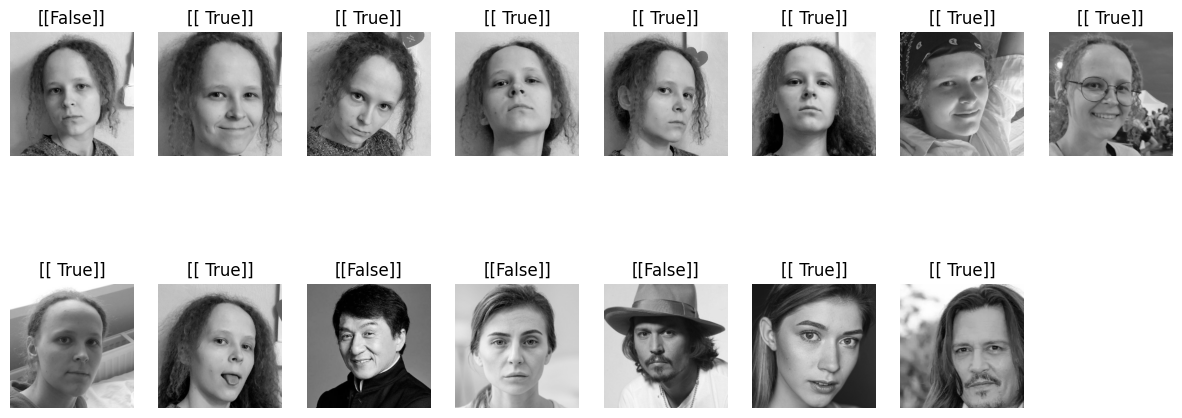

Итого 
 меня распознано 9/10, 
 ошибочно меня распознано 2/5


In [35]:
def is_not_you(your_embedding, test_embedding, threshold=0.5):
    similarity = cosine_similarity(your_embedding, test_embedding)
    return similarity < threshold

plt.figure(figsize=(15, 6))
N = 16
s_me = 0
s_not_me = 0
for i in range(1, N):
    file_name = f"vlada_images/{i}.png"
    test_embedding = get_embedding(file_name)
    result = is_not_you(your_image_embedding, test_embedding)

    plt.subplot(2, int(N/2), i)
    plt.imshow(Image.open(file_name))
    plt.title(f"{result}")
    plt.axis('off')
    if i <= 10 and result:
        s_me += 1
    if i > 10 and result:
        s_not_me += 1
plt.show()
print(f"Итого \n меня распознано {s_me}/10, \n ошибочно меня распознано {s_not_me}/5")